In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.9 MB 10.4 MB/s 


In [3]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.8 MB 8.3 MB/s 
     |████████████████████████████████| 596 kB 29.9 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 47.6 MB 38 kB/s 
     |████████████████████████████████| 1.1 MB 26.5 MB/s 
     |████████████████████████████████| 90 kB 8.2 MB/s 
     |████████████████████████████████| 213 kB 53.9 MB/s 
     |████████████████████████████████| 1.2 MB 46.2 MB/s 
     |████████████████████████████████| 99 kB 7.7 MB/s 
     |████████████████████████████████| 352 kB 61.8 MB/s 


In [4]:
#import required libraries
import pandas as pd
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

In [5]:
print(tf.__version__)

2.7.0


In [6]:
train_dir = '/content/gdrive/MyDrive/TrainingData'   #define your training data path here

In [7]:
# create dataset compatible to feed to the model
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 2   #data is fed in batches to the model. Increase this number for larger dataset in power of 2 like 2,4,8,16,32
seed = 42        # this is used to reproduce same results

#Below function used to create training dataset in tf.Data.Dataset format
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,  
    label_mode='int',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

# You can get class_names from below attribute
class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE) #This will prefetch the next batch and cache your data for faster processing


#make your validation dataset
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    label_mode='int',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 256 files belonging to 16 classes.
Using 205 files for training.
Found 256 files belonging to 16 classes.
Using 51 files for validation.


In [8]:
#This is used to check your training data and labels
for text_batch, label_batch in train_ds.take(1):
  for i in range(2):
    print(f'Text: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Text: b'Irlt\xc3\x84I Barry Satchell 24 Canberra Ave Lynfield AUCKLAND\n\nsion Consent Application Land Use / Subdivi Oct 2020\n\nPrepared For:\n\n24 Canberra Ave   60 New North Road, Mt Eden\nLynfield          PO Box 10 343             \nAuckland 1042     Auckland, New Zealand     \n\nPrepared By:\n\nApproved By:\n\nEric Xie\n\nA\n\n24 Canberra Avenue, Lynfield Resource Consent Application\n\n24 Canberra Ave\n\nLynfield AUCKLAND Land Use/ Subdivision Consent\n\nApplication\n\nBarry Satchell Consultants Limited\n\n\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6. Chris Kitson Planning Consultant BTP\n\n\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6\xe2\x80\xa6. Paul Wilson Director NZCE (Civil), REA, MIPENZ (Civil), CPEng, MNZIM\n\nTele

In [9]:
#define your bert model
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

#model name and respective urls are mapped below
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}


#model name and respective preprocessing models are mapped below
map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]  #select URL for chosen model
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name] # select URL for chosen preprocess model

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [10]:
#Build your bert model
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')  #define your input
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') #define preprocessing bert layer(This layer takes care of preprocessing steps required in bert model)
  encoder_inputs = preprocessing_layer(text_input) #define preprocessing steps for the data so that they can be fed to bert model
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')  #define bert model
  outputs = encoder(encoder_inputs) #Pass preprocessed data to bert model
  net = outputs['pooled_output']    # outputs are taken from pooled output layer in bert model 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(16, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [11]:
#define model and check how the model looks
classifier_model = build_classifier_model() 
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

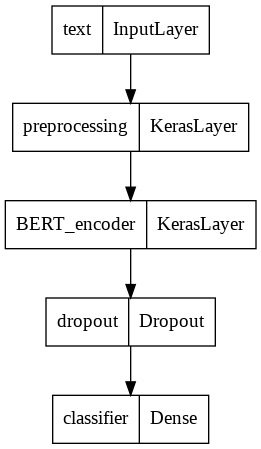

In [12]:
#plot your model
tf.keras.utils.plot_model(classifier_model)

In [13]:
epochs = 10    #This parameter defines how many complete data is seen by model. Increase this value for larger dataset
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy() #This parameter defines how many batches to be considerd in one epoch
num_train_steps = steps_per_epoch * epochs 
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5  #learning rate used during model training

#optimizer used during model training
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [14]:
#Compile model using optimizer. also define loss and performance_metric 
classifier_model.compile(optimizer=optimizer,
                         loss='sparse_categorical_crossentropy',
                         metrics='accuracy')

In [15]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
103/103 [==============================] - 113s 1s/step - loss: 2.8267 - accuracy: 0.1317 - val_loss: 2.6460 - val_accuracy: 0.2157
Epoch 2/10
103/103 [==============================] - 100s 976ms/step - loss: 2.1316 - accuracy: 0.3659 - val_loss: 2.1447 - val_accuracy: 0.3725
Epoch 3/10
103/103 [==============================] - 99s 966ms/step - loss: 1.2597 - accuracy: 0.7220 - val_loss: 1.6904 - val_accuracy: 0.5294
Epoch 4/10
103/103 [==============================] - 97s 943ms/step - loss: 0.7590 - accuracy: 0.8585 - val_loss: 1.5180 - val_accuracy: 0.5098
Epoch 5/10
103/103 [==============================] - 98s 955ms/step - loss: 0.4319 - accuracy: 0.9268 - val_loss: 1.3802 - val_accuracy: 0.5686
Epoch 6/10
103/103 [==============================] - 98s 952ms/step - loss: 0.2779 - accuracy: 0.9463 - val_loss: 1.2963 - val_accuracy: 0.6078
Epoch 7/10
103/103 [===================

In [18]:
#save model for future use
saved_model_path = '/content/gdrive/MyDrive'
classifier_model.save(saved_model_path, include_optimizer=False)

In [19]:
#reload saved model
reloaded_model = tf.saved_model.load(saved_model_path)

In [20]:
TestDataPath = '/content/gdrive/MyDrive/TestData'

In [24]:
#This function extracts filename, text data from text_files and make it in list format
def get_texts_files(TestDataPath):
  files = []
  texts = []
  for _, _ , filenames in os.walk(TestDataPath):
    for filename in filenames:
      files.append(filename)
      fullpathfile = os.path.join(TestDataPath,filename)
      with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
              intext = ''
              for line in infile:
                intext = intext + ' ' + line.replace('\n','')
              texts.append(intext)
  return texts, files


In [25]:
texts, files = get_texts_files(TestDataPath)

In [26]:
#prediction results
Results = reloaded_model(tf.constant(texts))

In [27]:
class_names = ['Application', 'Assessment', 'Calculations and Specification', 'Certificate', 'Checklist', 'Compliance', 
               'Consent Conditions', 'Correspondence', 'Financial Document', 'Legal Document', 'Meeting Document', 'Objection Submission',
               'Plan', 'ProducerStatement', 'Report', 'Site Investigation']

In [31]:
#This function will write results to csv
def write_results_csv(Results, files, class_names):
  FileName = []
  ClassName = []
  Confidence = []
  for i, result in enumerate(Results.numpy()):
    ind = result.argmax()
    FileName.append(files[i])
    ClassName.append(class_names[ind])
    Confidence.append(round(result.max() * 100, 2))
  final_results = {'FileName':FileName, 'ClassName': ClassName, 'Confidence': Confidence}
  df = pd.DataFrame(final_results)
  print(df)
  return df.to_csv('Results.csv')

In [32]:
write_results_csv(Results, files, class_names)

  FileName    ClassName  Confidence
0    2.txt  Application       99.90
1    9.txt  Application       99.91
2    0.txt  Application       99.92
3    4.txt  Application       99.92
4    3.txt  Application       99.91
5    5.txt  Application       99.91
6    8.txt  Application       99.49
7    1.txt  Application       98.82
8    6.txt  Application       99.92
9    7.txt  Application       99.15
